## Corrective RAG(CRAG)

Self-reflection can enhance RAG, enabling correction of poor quality retrieval or generations.

**Corrective Retrieval-Augmented Generation (CRAG) is a method that works like a built-in fact-checker.**

It adds both creativity and accuracy by creating text and then checking for any mistakes or made-up information. This helps make sure the final result is reliable and matches real-world facts. It's like a safety feature for AI writers, making their work more trustworthy and lowering the chances of spreading false information.

Here we'll see how to implement ideas from the Corrective RAG (CRAG) [Paper](https://arxiv.org/pdf/2401.15884.pdf) using LangGraph.

In [ ]:
# installing dependencies (in quiet mode)
!pip install langchain_community tiktoken langchain-openai lancedb langchain langchainhub langgraph tavily-python sentence-transformers -q

#### Set Tavily Search API Key for web search and OpenAI key

Tavily is a search engine specifically designed for AI agents and large language models (LLMs).

Get free credits [link](https://app.tavily.com/sign-in)

In [ ]:
import os

os.environ["TAVILY_API_KEY"] = "tvly-..."
os.environ["OPENAI_API_KEY"] = "sk-..."

Corrective-RAG (CRAG) is a recent paper that talks about a cool way to make a self-reflective RAG.

The method givesating/scores retrieved documents based on how well they answer a question:

For Correct documents -

1. If at least one document is really relevant, it moves on to creating text
2. Before creating text, it cleans up the knowledge
3. This breaks down the document into "knowledge strips"
4. It rates each strip and gets rid of ones that don't matter

For Ambiguous or Incorrect documents -
1. If all documents are not relevant enough or if it's not sure, the method looks for more information
2. It uses a web search to add more details to what it found
3. The diagram in the paper also show that they might change the question to get better results.

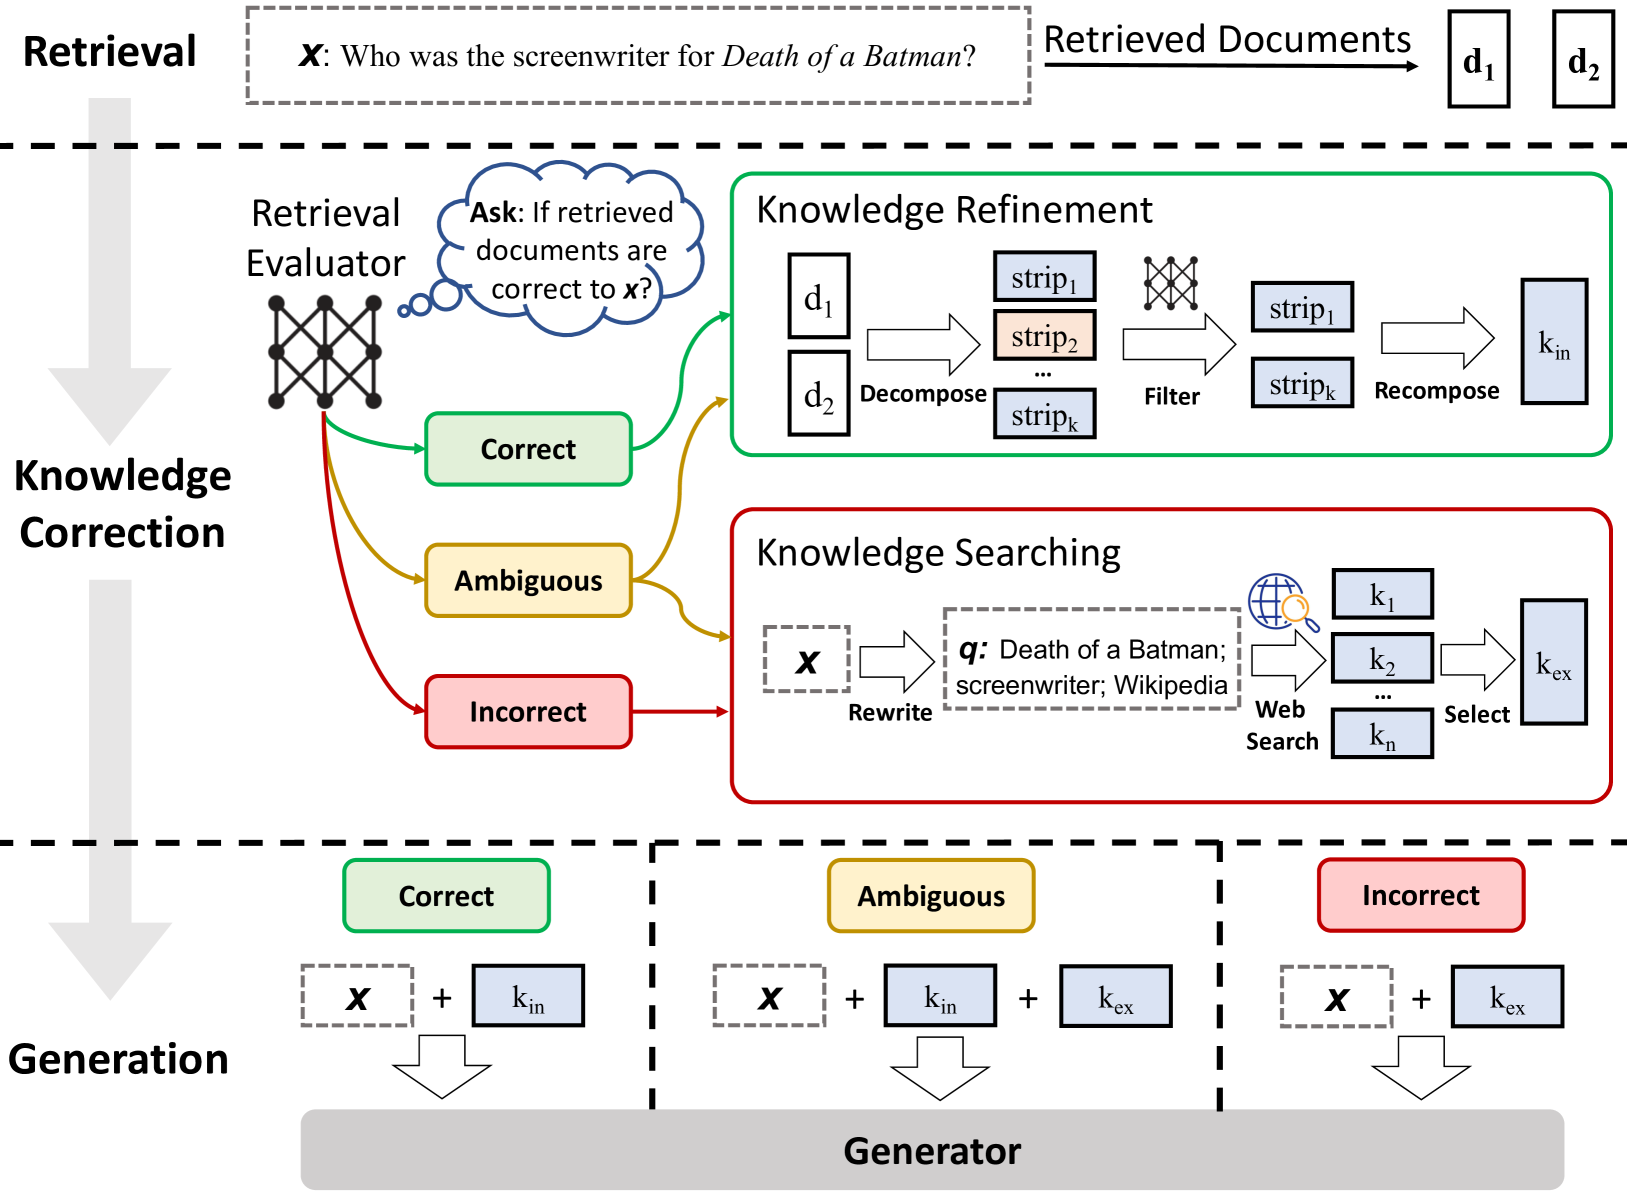

### Building Retriever

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import LanceDB
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# Using Jay Alammer's articles on Transformers, Bert and using transformers for retrival
urls = [
    "https://jalammar.github.io/illustrated-transformer/",
    "https://jalammar.github.io/illustrated-bert/",
    "https://jalammar.github.io/illustrated-retrieval-transformer/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# document chunking
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
import lancedb

def lanceDBConnection(embed):
    db = lancedb.connect("/tmp/lancedb")
    table = db.create_table(
        "crag_demo",
        data=[{"vector": embed.embed_query("Hello World"), "text": "Hello World"}],
        mode="overwrite",)

    return table

In [ ]:
# Huggingface embeddings
embedder = OpenAIEmbeddings()
# LanceDB as vector store
table = lanceDBConnection(embedder)
vectorstore = LanceDB.from_documents(
    documents=doc_splits,
    embedding=embedder,
    connection=table,
)

# ready with our retriever
retriever = vectorstore.as_retriever()

### Defining Langgraph
We will define a graph for building Langgraph.

We can access any Graph node as `state['keys']`.

In [ ]:
from typing import Dict, TypedDict

from langchain_core.messages import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        keys: A dictionary where each key is a string.
    """

    keys: Dict[str, any]

### Defining Nodes for Langgraph

### Nodes and Edges

Each Node will modify the state.

Each Edge will choose which node to call next.

Next Steps:
1. Retrieve Relevant Documents
2. If Relevant Document not found, Go for Supplement Retrieval with Web search(using Tavily API).
3. Query Re-writing to optimize the query for Web search.

Here is our graph flow:

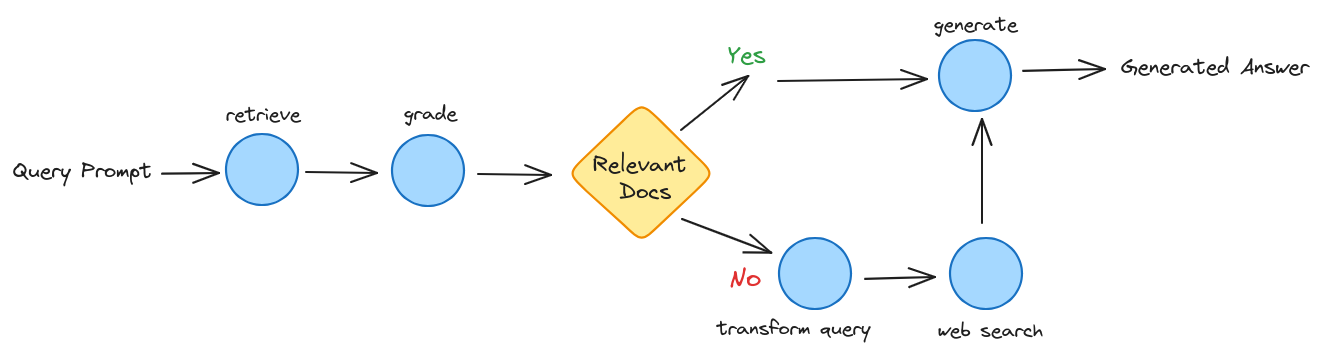


In [ ]:
import json
import operator
from typing import Annotated, Sequence, TypedDict

from langchain import hub
from langchain.output_parsers.openai_tools import PydanticToolsParser
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, FunctionMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.utils.function_calling import convert_to_openai_tool

def retrieve(state):
    """
    Helper function for retrieving documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("*"*5," RETRIEVE ", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = retriever.get_relevant_documents(question)
    return {"keys": {"documents": documents, "question": question}}

In [ ]:
def generate(state):
    """
    Helper function for generating answers

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("*"*5, " GENERATE ", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4-0125-preview", temperature=0, streaming=True)

    # Nested function for Post-processing retrieved docs
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # RAG Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {
        "keys": {"documents": documents, "question": question, "generation": generation}
    }

In [ ]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with relevant documents
    """

    print("*"*5, " DOCS RELEVANCE CHECK", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Tool
    grade_tool_oai = convert_to_openai_tool(grade)

    # LLM with tool and enforce invocation
    llm_with_tool = model.bind(
        tools=[convert_to_openai_tool(grade_tool_oai)],
        tool_choice={"type": "function", "function": {"name": "grade"}},
    )

    # Parser
    parser_tool = PydanticToolsParser(tools=[grade])

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool | parser_tool

    # Score
    filtered_docs = []
    search = "No"  # Default do not opt for web search to supplement retrieval
    for d in documents:
        score = chain.invoke({"question": question, "context": d.page_content})
        grade = score[0].binary_score
        if grade == "yes":
            print("*"*5, " RATED DOCUMENT: RELEVANT", "*"*5)
            filtered_docs.append(d)
        else:
            print("*"*5, " RATED DOCUMENT: NOT RELEVANT", "*"*5)
            search = "Yes"  # Perform web search when documents are not relevant
            continue

    return {
        "keys": {
            "documents": filtered_docs,
            "question": question,
            "run_web_search": search,
        }
    }

In [ ]:
def transform_query(state):
    """
    Helper function for transforming the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("*"*5, "TRANSFORM QUERY", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    # Create a prompt template with format instructions and the query
    prompt = PromptTemplate(
        template="""You are generating questions that is well optimized for retrieval. \n
        Look at the input and try to reason about the underlying sematic intent / meaning. \n
        Here is the initial question:
        \n --------- \n
        {question}
        \n --------- \n
        Formulate an improved question: """,
        input_variables=["question"],
    )

    # Grader model
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)

    # Prompt
    chain = prompt | model | StrOutputParser()
    better_question = chain.invoke({"question": question})

    return {"keys": {"documents": documents, "question": better_question}}

In [ ]:
def web_search(state):
    """
    Helper function to do Web search based on the re-phrased question using Tavily API.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("*"*5, " WEB SEARCH ", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    documents = state_dict["documents"]

    tool = TavilySearchResults()
    docs = tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"keys": {"documents": documents, "question": question}}

### Graph Edges

In [ ]:
def decide_to_generate(state):
    """
    Helper function to determine whether to generate an answer or re-generate a question for web search.

    Args:
        state (dict): The current state of the agent, including all keys.

    Returns:
        str: Next node to call
    """

    print("*"*5, " DECIDE TO GENERATE ", "*"*5)
    state_dict = state["keys"]
    question = state_dict["question"]
    filtered_documents = state_dict["documents"]
    search = state_dict["run_web_search"]

    if search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("*"*5, " DECISION: TRANSFORM QUERY and RUN WEB SEARCH ", "*"*5)
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("*"*5, " DECISION: GENERATE ", "*"*5)
        return "generate"

### Build Graph
Follow the flow we outlined in the figure above.

In [ ]:
import pprint

from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve docs
workflow.add_node("grade_documents", grade_documents)  # grade retrieved docs
workflow.add_node("generate", generate)  # generate answers
workflow.add_node("transform_query", transform_query)  # transform_query for web search
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search")
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [ ]:
# Run
query_prompt = "How Transformers work?"
inputs = {"keys": {"question": query_prompt}}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        # print full state at each node
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("------------------------")

# Final generation
print("*"*5, " Generated Answer ", "*"*5)
pprint.pprint(value["keys"]["generation"])

*****  RETRIEVE  *****
{ 'documents': [ Document(page_content='Featured in courses at Stanford, Harvard, MIT, Princeton, CMU and others\nIn the previous post, we looked at Attention – a ubiquitous method in modern deep learning models. Attention is a concept that helped improve the performance of neural machine translation applications. In this post, we will look at The Transformer – a model that uses attention to boost the speed with which these models can be trained. The Transformer outperforms the Google Neural Machine Translation model in specific tasks. The biggest benefit, however, comes from how The Transformer lends itself to parallelization. It is in fact Google Cloud’s recommendation to use The Transformer as a reference model to use their Cloud TPU offering. So let’s try to break the model apart and look at how it functions.', metadata={'vector': [-0.03292850777506828, 0.0013406849466264248, 0.021762628108263016, -0.010678051970899105, 0.0201500803232193, 0.01424191985279321

In [ ]:
# Correction for question not present in context
inputs = {
    "keys": {
        "question": "What is Vision transformer and How it is different from traditional transformers?"
    }
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        # print full state
        pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint.pprint("------------------------")

# Final generation
print("*"*5, " Generated Answer ", "*"*5)
pprint.pprint(value["keys"]["generation"])

*****  RETRIEVE  *****
{ 'documents': [ Document(page_content='Featured in courses at Stanford, Harvard, MIT, Princeton, CMU and others\nIn the previous post, we looked at Attention – a ubiquitous method in modern deep learning models. Attention is a concept that helped improve the performance of neural machine translation applications. In this post, we will look at The Transformer – a model that uses attention to boost the speed with which these models can be trained. The Transformer outperforms the Google Neural Machine Translation model in specific tasks. The biggest benefit, however, comes from how The Transformer lends itself to parallelization. It is in fact Google Cloud’s recommendation to use The Transformer as a reference model to use their Cloud TPU offering. So let’s try to break the model apart and look at how it functions.', metadata={'vector': [-0.03292850777506828, 0.0013406849466264248, 0.021762628108263016, -0.010678051970899105, 0.0201500803232193, 0.01424191985279321